In [1]:
# License: BSD
# Author: Sasank Chilamkurthy
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision

import numpy as np
import time
from os.path import join
import copy

from loader.idrid_loader import create_idrid_loader

from torchvision import transforms
#import keras_transforms as transforms2

#from models.refinenet_4cascade import RefineNet4Cascade
from models.unet import UNet

import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'cv2'

# Load Data

In [2]:
'''def train_transforms(image, mask):
    
    # Convert PIL image to 3D numpy
    image = transforms2.img_to_array(image, data_format='channels_last')
    mask = transforms2.img_to_array(mask, data_format='channels_last')
    #print(image.shape)
    
    #result = transforms2.random_rotation([image, mask], 45, fill_mode='constant')
    #image, mask = result[0], result[1]
    #result = transforms2.random_zoom([image, mask], (0.5, 1.5))
    #image, mask = result[0], result[1]
    #image = transforms2.flip_axis(image, 2)
    #result = transforms2.random_shift([image, mask], 0.2, 0.3, fill_mode='nearest')
    #image, mask = result[0], result[1]
    #print('-->', image.shape)
    #print('-->', mask.shape)
    
    #result = transforms2.random_shear([image, mask], 1.5, fill_mode='constant')
    #image, mask = result[0], result[1]
    #print('222', image.shape)
    
    #image = transforms2.random_channel_shift(image, 0.6)
    
    # Convert 3D numpy to PIL image
    image = transforms2.array_to_img(image, data_format='channels_last', scale=False)
    mask = transforms2.array_to_img(mask, data_format='channels_last', scale=False)
    #print('222', image.size)
    #image = transforms.RandomHorizontalFlip()(image)
        
    # Convert PIL image to Pytorch tensor
    image = transforms.ToTensor()(image)
    mask = transforms.ToTensor()(mask)
    #print('-->', mask.shape)
    
    return image, mask'''

def train_transforms(image, mask):
    image = transforms.Resize((128, 128))(image)
    mask = transforms.Resize((128, 128))(mask)
    image = transforms.ToTensor()(image)
    mask = transforms.ToTensor()(mask)
    #print('->', mask.shape)
    return image, mask

def valid_transforms(image, mask):
    image = transforms.Resize((128, 128))(image)
    mask = transforms.Resize((128, 128))(mask)
    image = transforms.ToTensor()(image)
    mask = transforms.ToTensor()(mask)
    return image, mask

data_transforms = {
    'train': train_transforms,
    'val': valid_transforms
}

data_dir = 'inputs'
image_datasets = {x: create_idrid_loader('{}/{}/'.format(data_dir, x), 
                                         '{}/{}_masks/'.format(data_dir, x), 
                                         transform=data_transforms[x], cache = False)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=3,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

use_gpu = torch.cuda.is_available()

77 0
77 0
10 0
10 0


In [3]:
samples = next(iter(dataloaders['train']))

- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)
- (1918, 1280)
-- (1918, 1280)


# Visualize a few images

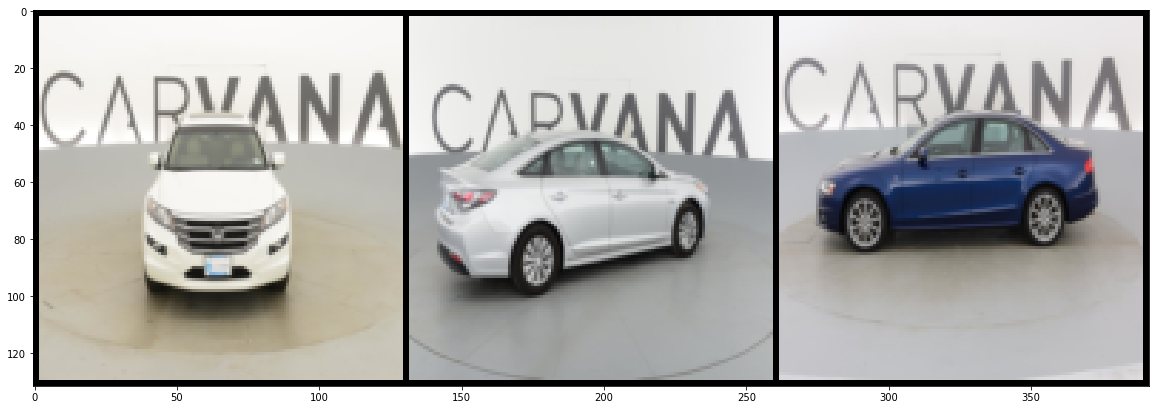

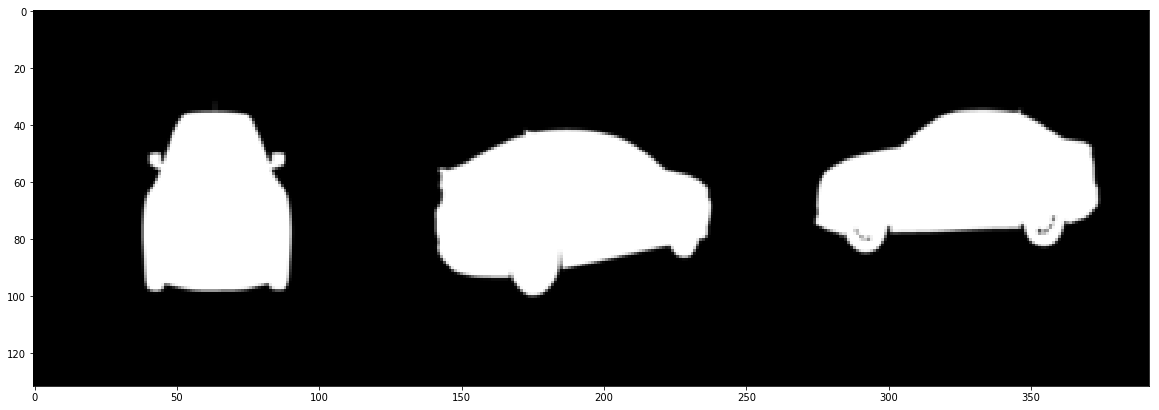

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    if inp.shape[2] == 1:
        inp = np.squeeze(inp)
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
samples = next(iter(dataloaders['train']))
#print(samples['raw'].shape)
#print('-->', samples['label'].shape)

# Make a grid from batch
imgs = torchvision.utils.make_grid(samples['raw'])
masks = torchvision.utils.make_grid(samples['label'])
#print('--->', imgs.shape)
#print('--->', masks.shape)

imshow(imgs)
imshow(masks)

# Training the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, threshold=0.5):
    since = time.time()
    
    if torch.cuda.is_available():
        model = model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss_evaluating = 99999999

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        epoch_loss_training = 0.0
        epoch_loss_evaluating = 0.0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            batch_loss_training = 0.0
            batch_loss_evaluating = 0.0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data['raw'], data['label']

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda()).type(torch.LongTensor)
                else:
                    inputs, labels = Variable(inputs), Variable(labels).type(torch.LongTensor)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                logits = model(inputs)
                probs_map  = F.sigmoid(logits)
                masks  = (probs_map > threshold).float()
                
                print('->', logits.shape)
                print('-->', labels.shape)
                loss_for_training = criterion(logits, labels)
                loss_for_evaluating  = dice_loss(masks, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss_for_training.backward()
                    optimizer.step()

                # statistics
                batch_loss_training += loss_for_training.data[0] * inputs.size(0)
                batch_loss_evaluating += loss_for_evaluating.data[0] * inputs.size(0)

            epoch_loss_training = batch_loss_training / dataset_sizes[phase]
            epoch_loss_evaluating = batch_loss_evaluating / dataset_sizes[phase]
                        
            print('{} epoch {}/{} Loss_training: {:.4f}, Loss_evaluating: {:.4f}'.format(phase, 
                                                                                         epoch, 
                                                                                         num_epochs, 
                                                                                         epoch_loss_training, 
                                                                                         epoch_loss_evaluating))
            # deep copy the model
            if phase == 'val' and epoch_loss_evaluating < best_loss:
                best_loss_evaluating = epoch_loss_evaluating
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_loss_evaluating))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Config Model

In [5]:
#model = RefineNet4Cascade((128, 128), num_classes=1)
model = UNet(1, depth=5, merge_mode='concat')
for param in model.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train and evaluate

In [6]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
-> torch.Size([3, 1, 128, 128])
--> torch.Size([3, 1, 128, 128])


RuntimeError: invalid argument 3: only batches of spatial targets supported (3D tensors) but got targets of dimension: 4 at /opt/conda/conda-bld/pytorch_1518243271935/work/torch/lib/THNN/generic/SpatialClassNLLCriterion.c:60